Author: Sabayna Ali  
Github Link:  
Code Topic: Exploring the trends between mobile services users, their devices and revenue generation.   
About Dataset: The dataset I have used for this analysis was collected from public sources for a Telecom case study. Its divided into three data files for Customers, IOT devices and Revenue. Following is the columns details of the files:  
**CUSTOMER ATTRIBUTE DESCRIPTION**         
msisdn  : Unique identification number assigned to each mobile number  
gender  : sex of the customer using the mobile service  
year_of_birth  : year of birth of the customer  
system_status  : indicates the status of the mobile service being used by the customer  
mobile_type  : Customers can choose their service as prepaid or postpaid  
value_segment  : Segmentation based on how well the customer matches the business goals  
**IOT DEVICES ATTRIBUTE DESCRIPTION**  
msisdn: Unique identification number assigned to each mobile number  
imei_tac: Unique identification number assigned to the location of the mobile service  
brand_name: The brand of the mobile  
model_name: The model of the mobile  
os_name: The Operating System of the mobile  
os_vendor: The company of the mobile operating system  
**REVENUE ATTRIBUTE DESCRIPTION**  
msisdn  : Unique identification number assigned to each mobile number  
week_number : Week number for the particular year  
Revenue_usd : Revenue generated in that week in US dollars  

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

# Data Exploration, Cleaning and Preparing for Analysis
I have merged the three csv files on msisdn number and dropped some unnecessary rows and columns. Since there were a lot of null values in gender column (46294), I first calculated the male-female distribution and based on those probabilties randomly assigned values to missing entries so that original proportion of genders remain same and data isnt skewed. Then I calculated age from birth year and grouped the whole dataframe by msisdn number. 

In [2]:
# Loading the datasets with only the required columns
cust_df = pd.read_csv("crm1.csv", sep=',')
dev_df = pd.read_csv("device1.csv", sep=',', usecols=['msisdn','brand_name'])
rev_df = pd.read_csv("rev1.csv", sep =',', usecols=['msisdn', 'revenue_usd'])
# Merge datasets
merged_df = cust_df.merge(dev_df, on="msisdn", how="inner")
merged_df = merged_df.merge(rev_df, on="msisdn", how="inner")
# Dropping the rows where system_status is 'suspend' because we are only looking for active mobile service users 
merged_df.drop(merged_df.loc[merged_df['system_status'] =='SUSPEND'].index, inplace=True)
# Dropping unnecessary columns from the data
merged_df.drop(columns= ['system_status'], inplace = True)
# Standardize gender values
merged_df['gender'] = merged_df['gender'].str.replace( r'^(?i)m(ale)?$', 'Male', regex=True).str.replace( r'^(?i)f(emale)?$', 'Female', regex=True)
# Calculate the distribution of gender
gender_distribution = merged_df['gender'].value_counts(normalize=True)
# Randomly assign missing values in gender based on the distribution
merged_df['gender'] = merged_df['gender'].apply(lambda x: np.random.choice(gender_distribution.index, p=gender_distribution.values) if pd.isna(x) else x)
# Impute missing brand_name values with a placeholder ('Unknown')
merged_df['brand_name'].fillna('Unknown', inplace=True)
# Drop rows where year_of_birth is NaN
merged_df = merged_df.dropna(subset=['year_of_birth'])
# Calculate age from year of birth till the year dataset was last updated 
merged_df['age'] = 2020 - merged_df['year_of_birth']
#Converting revenue from float to integer
merged_df = merged_df.assign(revenue= merged_df.get('revenue_usd').astype(int))
merged_df = merged_df.drop(columns= ['revenue_usd'])
# Grouping the dataframe by msisdn since we want to see revenue trends per customer
merged_df = merged_df.groupby('msisdn').agg({'revenue': 'sum','gender': 'first','year_of_birth': 'first','mobile_type': 'first','value_segment': 'first','brand_name': 'first','age': 'first'}).reset_index()

# Exploratory Data Analysis (EDA)
I have made a few graphs to explore the trends between:

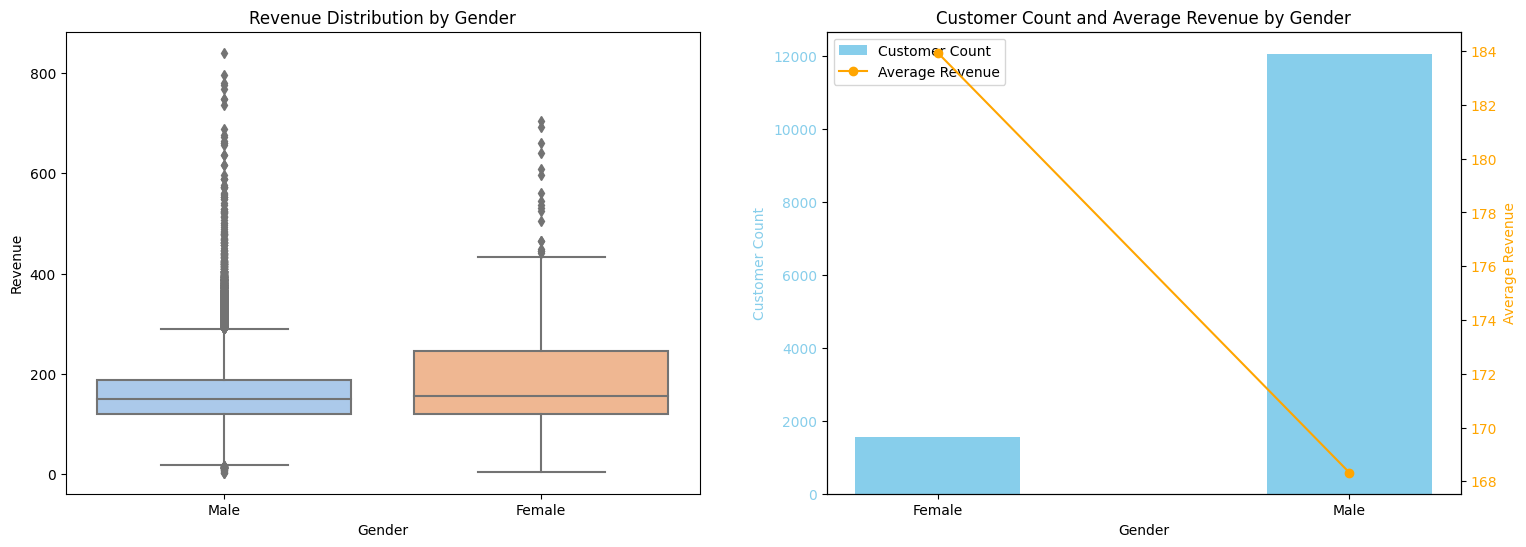

In [6]:
gender_summary = merged_df.groupby("gender").agg(customer_count=("msisdn", "nunique"),average_revenue=("revenue", "mean")).reset_index()
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
# Boxplot for Revenue Distribution by Gender
sns.boxplot(data=merged_df, x="gender", y="revenue", palette="pastel", ax=axes[0])
axes[0].set_title("Revenue Distribution by Gender")
axes[0].set_xlabel("Gender")
axes[0].set_ylabel("Revenue")
# Combined Bar and Line Chart for Customer Count and Average Revenue
axes[1].bar(gender_summary["gender"], gender_summary["customer_count"], color="skyblue", width=0.4, label="Customer Count")
axes[1].set_ylabel("Customer Count", color="skyblue")
axes[1].tick_params(axis="y", labelcolor="skyblue")
axes[1].set_xlabel("Gender")
ax2 = axes[1].twinx()
ax2.plot(gender_summary["gender"], gender_summary["average_revenue"], color="orange", marker="o", label="Average Revenue")
ax2.set_ylabel("Average Revenue", color="orange")
ax2.tick_params(axis="y", labelcolor="orange")
axes[1].set_title("Customer Count and Average Revenue by Gender")
lines1, labels1 = axes[1].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axes[1].legend(lines1 + lines2, labels1 + labels2, loc="upper left")
plt.subplots_adjust(wspace=0.2)
plt.show()

1. **Gender & Revenue**, as this can help companies target a specific customer demographic in their adverstisments, in this case female customers are generating more revenue despite being less in number. 

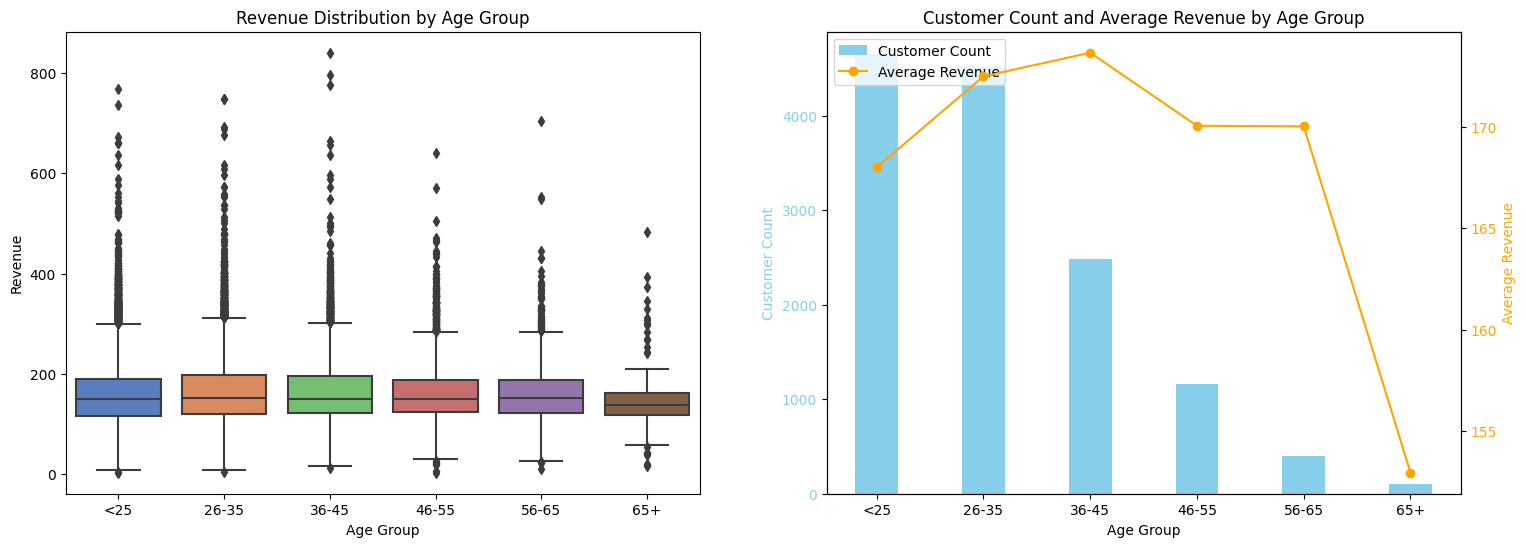

In [15]:
# Define age bins and labels
age_bins = [25, 35, 45, 55, 65, 75, 100]
age_labels = ['<25', '26-35', '36-45', '46-55', '56-65', '65+']
merged_df['age_group'] = pd.cut(merged_df['age'], bins=age_bins, labels=age_labels, right=False)
age_summary = merged_df.groupby("age_group").agg( customer_count=("msisdn", "nunique"),average_revenue=("revenue", "mean")).reset_index()
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
# Boxplot for age groups vs revenue
sns.boxplot(data=merged_df, x="age_group", y="revenue", palette="muted", ax=axes[0])
axes[0].set_title("Revenue Distribution by Age Group")
axes[0].set_xlabel("Age Group")
axes[0].set_ylabel("Revenue")
axes[1].bar(age_summary["age_group"], age_summary["customer_count"], color="skyblue", width=0.4, label="Customer Count")
axes[1].set_ylabel("Customer Count", color="skyblue")
axes[1].tick_params(axis="y", labelcolor="skyblue")
axes[1].set_xlabel("Age Group")
ax2 = axes[1].twinx()
ax2.plot(age_summary["age_group"], age_summary["average_revenue"], color="orange", marker="o", label="Average Revenue")
ax2.set_ylabel("Average Revenue", color="orange")
ax2.tick_params(axis="y", labelcolor="orange")
axes[1].set_title("Customer Count and Average Revenue by Age Group")
lines1, labels1 = axes[1].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axes[1].legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.subplots_adjust(wspace=0.2)
plt.show()

2. **Age groups & Revenue**, similarly can be helpful in product stratgies for example in this case age group 26-45 is contributing the most in revenue. 

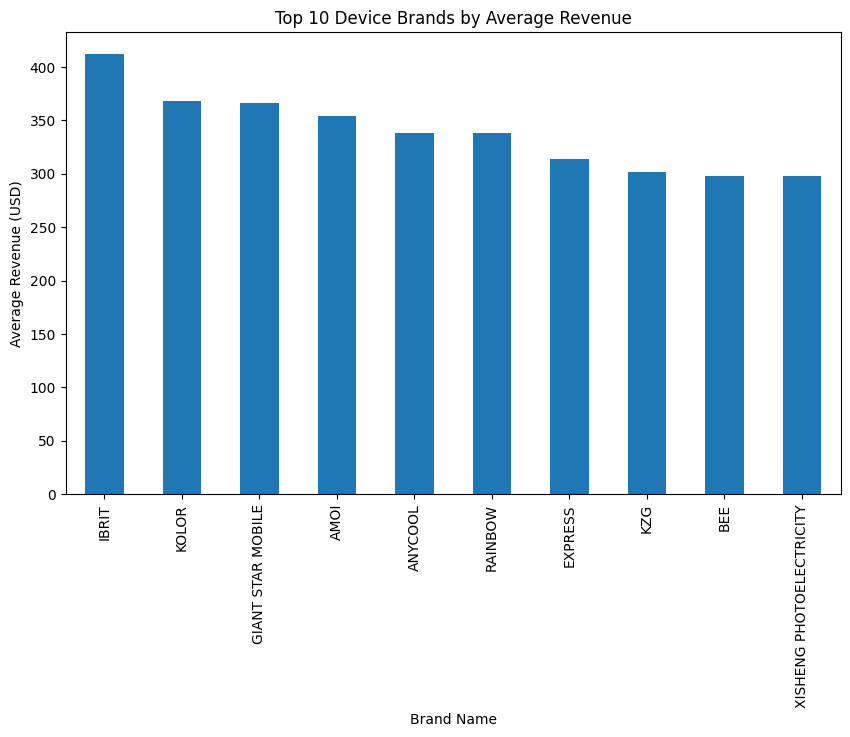

In [7]:
avg_revenue_by_brand = merged_df.groupby("brand_name")["revenue"].mean().sort_values(ascending=False)
avg_revenue_by_brand.head(10).plot(kind="bar", figsize=(10, 6))
plt.title("Top 10 Device Brands by Average Revenue")
plt.xlabel("Brand Name")
plt.ylabel("Average Revenue (USD)")
plt.show()

3. **Mobile Brand & Revenue** as some brand holders are generating more revenue than others, there can be promotional offers including those brands. 

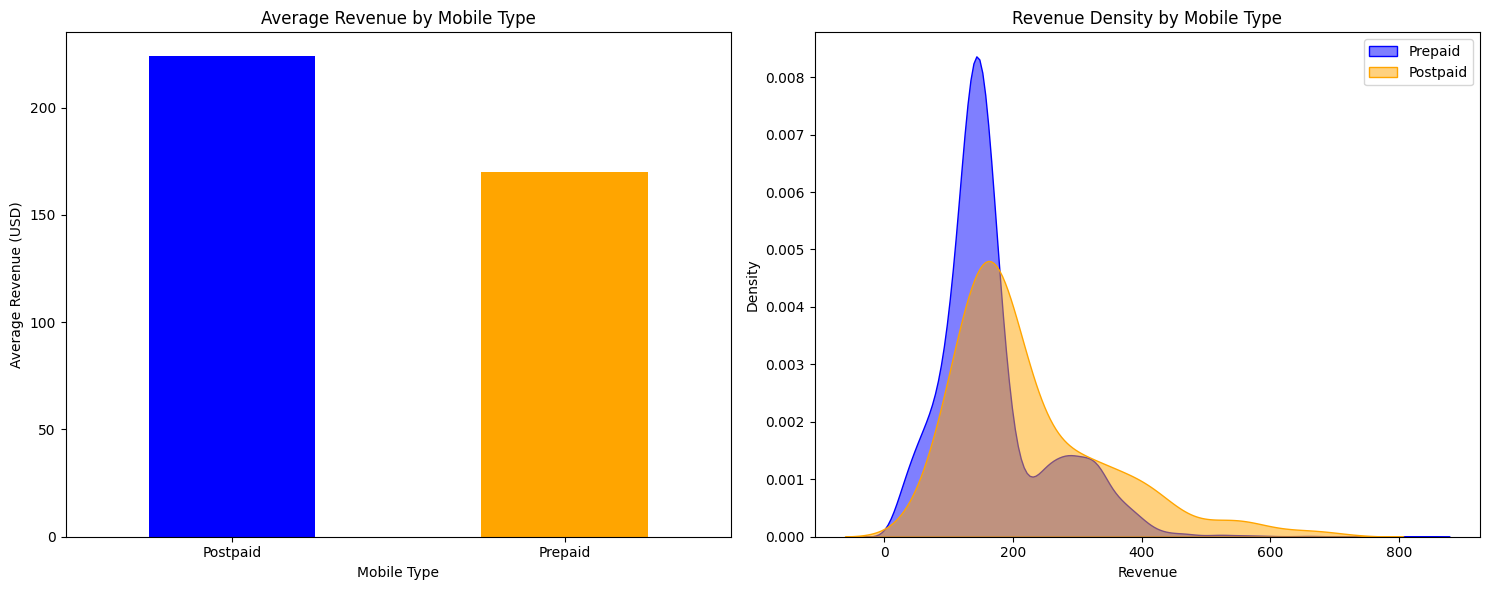

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
# Bar Chart for average revenue by mobile type
revenue_by_mobile_type = merged_df.groupby("mobile_type")["revenue"].mean()
revenue_by_mobile_type.plot(kind="bar", color=["blue", "orange"], ax=axes[0])
axes[0].set_title("Average Revenue by Mobile Type")
axes[0].set_xlabel("Mobile Type")
axes[0].set_ylabel("Average Revenue (USD)")
axes[0].tick_params(axis='x', rotation=0)
# Density Plot
sns.kdeplot(data=merged_df[merged_df['mobile_type'] == 'Prepaid'], x="revenue", fill=True, alpha=0.5, ax=axes[1], color='blue', label='Prepaid')
sns.kdeplot(data=merged_df[merged_df['mobile_type'] == 'Postpaid'], x="revenue", fill=True, alpha=0.5, ax=axes[1], color='orange', label='Postpaid')
axes[1].set_title("Revenue Density by Mobile Type")
axes[1].set_xlabel("Revenue")
axes[1].set_ylabel("Density")
axes[1].legend()
plt.tight_layout()
plt.show()

4.**Post or Prepaid Analysis**: As postpaid users are high-value csutomers depsite being less in number, more discounts or offers could be made for customers to shift them to postpaid. 